In [52]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [7]:
# 1. Load the data (adjust path as needed)
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [8]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [9]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [10]:
# 3. Sort by time (needed for lag features)
df = df.sort_values('date_time').reset_index(drop=True)

In [12]:
# 4. Holiday flag
df['is_holiday'] = df['holiday'] != 'None'
df['holiday'] = df['holiday'].replace('None', pd.NA)

In [14]:
# 5. Extract raw datetime features
df['hour']    = df['date_time'].dt.hour
df['day']     = df['date_time'].dt.day
df['month']   = df['date_time'].dt.month
df['weekday'] = df['date_time'].dt.weekday  # Monday=0 … Sunday=6

In [16]:
# 6. Cyclical encodings for time components
df['hour_sin']    = np.sin(2 * np.pi * df['hour']    / 24)
df['hour_cos']    = np.cos(2 * np.pi * df['hour']    / 24)
df['day_sin']     = np.sin(2 * np.pi * df['day']     / 31)
df['day_cos']     = np.cos(2 * np.pi * df['day']     / 31)
df['month_sin']   = np.sin(2 * np.pi * df['month']   / 12)
df['month_cos']   = np.cos(2 * np.pi * df['month']   / 12)
df['wday_sin']    = np.sin(2 * np.pi * df['weekday'] / 7)
df['wday_cos']    = np.cos(2 * np.pi * df['weekday'] / 7)

In [18]:
# 7. Lag features for traffic_volume
df['lag_1']             = df['traffic_volume'].shift(1)
df['rolling_mean_3']    = df['traffic_volume'].shift(1).rolling(window=3).mean()
df['rolling_mean_24']   = df['traffic_volume'].shift(1).rolling(window=24).mean()
df['rolling_std_24']    = df['traffic_volume'].shift(1).rolling(window=24).std()

In [21]:
# 8. Fill or drop NaNs created by shifting/rolling
df.fillna(0, inplace=True)

In [24]:
# 9. One-hot encode categorical weather features
df = pd.get_dummies(
    df,
    columns=['weather_main', 'weather_description'],
    drop_first=True
)

In [27]:
# 10. Scale continuous features
numeric_cols = [
    'temp', 'rain_1h', 'snow_1h', 'clouds_all',
    'lag_1', 'rolling_mean_3', 'rolling_mean_24', 'rolling_std_24',
    'hour_sin', 'hour_cos',
    'day_sin', 'day_cos',
    'month_sin', 'month_cos',
    'wday_sin', 'wday_cos'
]
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [32]:
# 10. Time-based train/test split (first 80% train, last 20% test)
n_train = int(len(df) * 0.8)
X = df.drop(columns=['traffic_volume','date_time','holiday'])
y = df['traffic_volume']
X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]

In [33]:
# 11. Fit simple linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
# 12. Predict & evaluate
y_pred = lr.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE:  {mse:.2f}")
print(f"Test RMSE: {np.sqrt(mse):.2f}")
print(f"Test R²:   {r2:.4f}")

Test MSE:  296759.60
Test RMSE: 544.76
Test R²:   0.9234


/var/folders/5v/hnnzd2qj7nj943r8l1286zsc0000gn/T/ipykernel_67983/2145755036.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_time'] = pd.to_datetime(df['date_time'])


(48204,)


/opt/miniconda3/envs/cs221/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1084/1084 - 5s - 5ms/step - loss: 0.2553 - val_loss: 0.1118
Epoch 2/50
1084/1084 - 5s - 4ms/step - loss: 0.1174 - val_loss: 0.0846
Epoch 3/50
1084/1084 - 5s - 4ms/step - loss: 0.0950 - val_loss: 0.0714
Epoch 4/50
1084/1084 - 5s - 4ms/step - loss: 0.0851 - val_loss: 0.0582
Epoch 5/50
1084/1084 - 5s - 4ms/step - loss: 0.0799 - val_loss: 0.0589
Epoch 6/50
1084/1084 - 5s - 4ms/step - loss: 0.0767 - val_loss: 0.0560
Epoch 7/50
1084/1084 - 5s - 5ms/step - loss: 0.0738 - val_loss: 0.0501
Epoch 8/50
1084/1084 - 5s - 4ms/step - loss: 0.0707 - val_loss: 0.0478
Epoch 9/50
1084/1084 - 5s - 5ms/step - loss: 0.0696 - val_loss: 0.0467
Epoch 10/50
1084/1084 - 5s - 4ms/step - loss: 0.0676 - val_loss: 0.0419
Epoch 11/50
1084/1084 - 5s - 4ms/step - loss: 0.0656 - val_loss: 0.0424
Epoch 12/50
1084/1084 - 5s - 4ms/step - loss: 0.0645 - val_loss: 0.0410
Epoch 13/50
1084/1084 - 5s - 5ms/step - loss: 0.0632 - val_loss: 0.0438
Epoch 14/50
1084/1084 - 5s - 5ms/step - loss: 0.0618 - val_loss: 0.0408
E

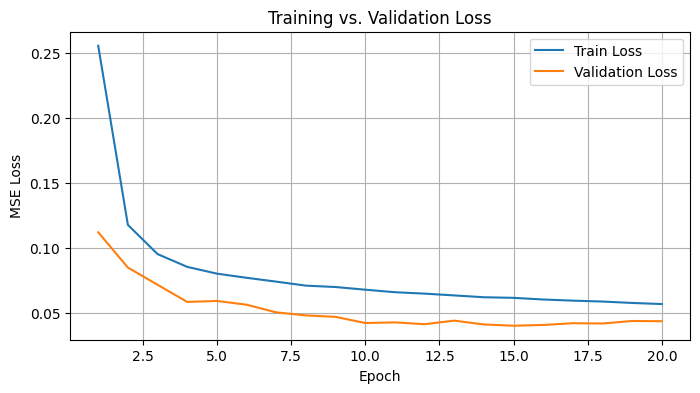

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score

# --- 1. Load & parse ---
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time').reset_index(drop=True)

# --- 2. Wavelet denoising function ---
def wavelet_denoise(signal, wavelet='db4', level=None):
    """
    Denoise a 1D signal using soft-thresholding on wavelet detail coefficients.
    """
    # Decompose
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)
    # Estimate noise sigma from the first detail coeffs
    detail_coeffs = coeffs[-1]
    sigma = np.median(np.abs(detail_coeffs)) / 0.6745
    # Universal threshold
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    # Threshold all detail coefficients
    coeffs_denoised = [coeffs[0]] + [
        pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]
    ]
    # Reconstruct
    return pywt.waverec(coeffs_denoised, wavelet, mode='per')[: len(signal)]

# --- 3. Apply denoising ---
df['traffic_volume_den'] = wavelet_denoise(df['traffic_volume'])

# --- 4. Holiday flag ---
df['is_holiday'] = (df['holiday'] != 'None').astype(int)
df['holiday']    = df['holiday'].replace('None', pd.NA)

# --- 5. Cyclical datetime features ---
for col, period in [('hour',24), ('day',31), ('month',12), ('wday',7)]:
    if col == 'wday':
        df[col] = df['date_time'].dt.weekday
    else:
        df[col] = getattr(df['date_time'].dt, col)
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)

# --- 6. Lag & rolling on denoised series ---
df['lag_1']        = df['traffic_volume_den'].shift(1)
df['roll_mean_3']  = df['traffic_volume_den'].shift(1).rolling(3).mean()
df['roll_mean_24'] = df['traffic_volume_den'].shift(1).rolling(24).mean()
df['roll_std_24']  = df['traffic_volume_den'].shift(1).rolling(24).std()

df.fillna(0, inplace=True)

# --- 7. One-hot encode weather ---
df = pd.get_dummies(
    df,
    columns=['weather_main','weather_description'],
    drop_first=True
)

# --- 8. Prepare features & target ---
# Use the denoised series as the target for modeling
y = df['traffic_volume_den'].to_numpy().astype('float32')
X = df.drop(columns=['traffic_volume', 'traffic_volume_den', 'date_time', 'holiday'])
print(y.shape)
# Identify numeric columns for scaling
num_cols = [
    'temp','rain_1h','snow_1h','clouds_all',
    'lag_1','roll_mean_3','roll_mean_24','roll_std_24'
] + [c for c in X.columns if c.endswith(('_sin','_cos'))]

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# y = scaler.fit_transform(Y_train)
y_scaler = StandardScaler()
y = y.reshape(len(y), 1)
y = y_scaler.fit_transform(y)

# Convert to NumPy
X_np = X.to_numpy(dtype='float32')

# --- 9. Time-based split ---
n_train = int(len(X_np) * 0.8)
X_train_np, X_test_np = X_np[:n_train], X_np[n_train:]
y_train_np, y_test_np = y[:n_train], y[n_train:]

# --- 10. Sequence creation ---
def create_sequences(X_arr, y_arr, seq_len=24):
    Xs, ys = [], []
    for i in range(seq_len, len(X_arr)):
        Xs.append(X_arr[i-seq_len:i])
        ys.append(y_arr[i])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 24
X_seq_train, y_seq_train = create_sequences(X_train_np, y_train_np, SEQ_LEN)
X_seq_test,  y_seq_test  = create_sequences(X_test_np,  y_test_np,  SEQ_LEN)

# --- 11. Manual validation split ---
n_val = int(0.1 * len(X_seq_train))
X_val = X_seq_train[-n_val:]
y_val = y_seq_train[-n_val:]
X_train_final = X_seq_train[:-n_val]
y_train_final = y_seq_train[:-n_val]

# --- 12. Build & compile LSTM ---
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_seq_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# --- 13. Train (no shuffle) ---
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_final, y_train_final,
    epochs=50, batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[es],
    verbose=2
)

# --- 14. Evaluate on test set ---
y_pred = model.predict(X_seq_test).flatten()
mse = mean_squared_error(y_seq_test, y_pred)
r2  = r2_score(y_seq_test, y_pred)
print(f"Test MSE:  {mse:.2f}")
print(f"Test RMSE: {np.sqrt(mse):.2f}")
print(f"Test R²:   {r2:.4f}")

# Extract loss & val_loss from history.history
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
epochs = list(range(1, len(train_loss)+1))

# Plot them
plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss,   label='Validation Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 21.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
